# Wilt anomaly detection

## Introduction

The data set differentiates diseased trees from other land covers. The former are considered outliers here.

#### Attribute information:
- `class`: 'w' (diseased trees), 'n' (all other land cover)

- `GLCM_Pan`: GLCM mean texture (Pan band)

- `Mean_G`: Mean green value

- `Mean_R`: Mean red value

- `Mean_NIR`: Mean NIR value

- `SD_Pan`: Standard deviation (Pan band)

## Imports

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.rcParams["figure.figsize"] = "25,10"
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.labelsize"] = 16

import os
import pandas_profiling as pp

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score

from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

## Loading the data

In [2]:
data_dir = "../data/anomaly-detection/wilt/"

train = pd.read_csv(os.path.join(data_dir, "training.csv"))
test = pd.read_csv(os.path.join(data_dir, "testing.csv"))

In [3]:
data = pd.concat([train, test], ignore_index=True, sort=False)

In [4]:
data.head()

class    GLCM_pan  Mean_Green    Mean_Red    Mean_NIR     SD_pan
0     w  120.362774  205.500000  119.395349  416.581395  20.676318
1     w  124.739583  202.800000  115.333333  354.333333  16.707151
2     w  134.691964  199.285714  116.857143  477.857143  22.496712
3     w  127.946309  178.368421   92.368421  278.473684  14.977453
4     w  135.431548  197.000000  112.690476  532.952381  17.604193

In [5]:
data = data[["GLCM_pan", "Mean_Green", "Mean_Red", "Mean_NIR", "SD_pan", "class"]]

In [6]:
data["class"] = data["class"].map({"w": 1, "n": 0})

In [7]:
data.describe(include="all").transpose()

count        mean         std         min         25%  \
GLCM_pan    4839.0  126.855547   13.450516    0.000000  118.758944   
Mean_Green  4839.0  231.412658   63.264941  117.210526  203.896429   
Mean_Red    4839.0  116.305331   62.005622   50.578947   91.527009   
Mean_NIR    4839.0  525.800301  156.579297   86.500000  415.448161   
SD_pan      4839.0   24.482007   10.726997    0.000000   17.679972   
class       4839.0    0.053937    0.225916    0.000000    0.000000   

                   50%         75%          max  
GLCM_pan    127.481872  134.947789   183.281250  
Mean_Green  219.260870  239.860577  1848.916667  
Mean_Red    101.631579  116.969687  1594.583333  
Mean_NIR    518.657143  635.133450  1597.333333  
SD_pan       23.198396   29.326445   156.508431  
class         0.000000    0.000000     1.000000

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839 entries, 0 to 4838
Data columns (total 6 columns):
GLCM_pan      4839 non-null float64
Mean_Green    4839 non-null float64
Mean_Red      4839 non-null float64
Mean_NIR      4839 non-null float64
SD_pan        4839 non-null float64
class         4839 non-null int64
dtypes: float64(5), int64(1)
memory usage: 226.9 KB


## Pandas profile

In [9]:
pp.ProfileReport(data)

## Exploratory Data Analysis (EDA)

In [9]:
# examining counts of target variable
np.unique(data["class"], return_counts=True)

(array([0, 1]), array([4578,  261]))

In [10]:
features = ["GLCM_pan", "Mean_Green", "Mean_NIR", "Mean_Red", "SD_pan"]

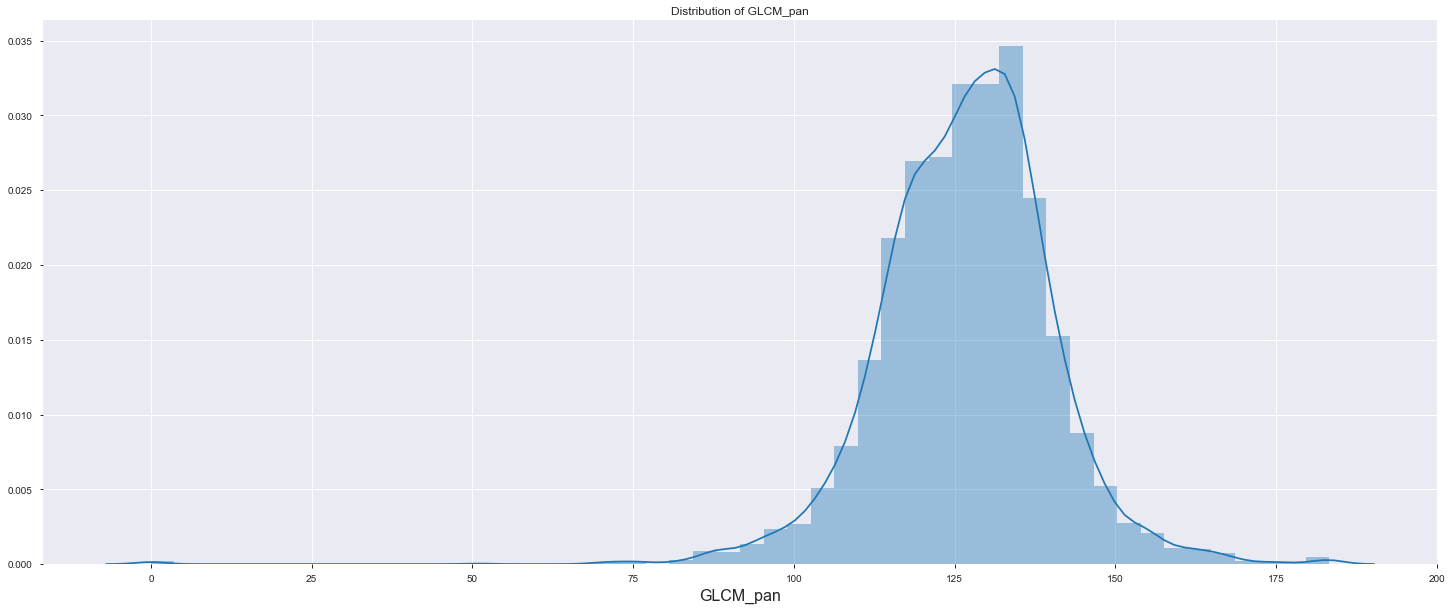

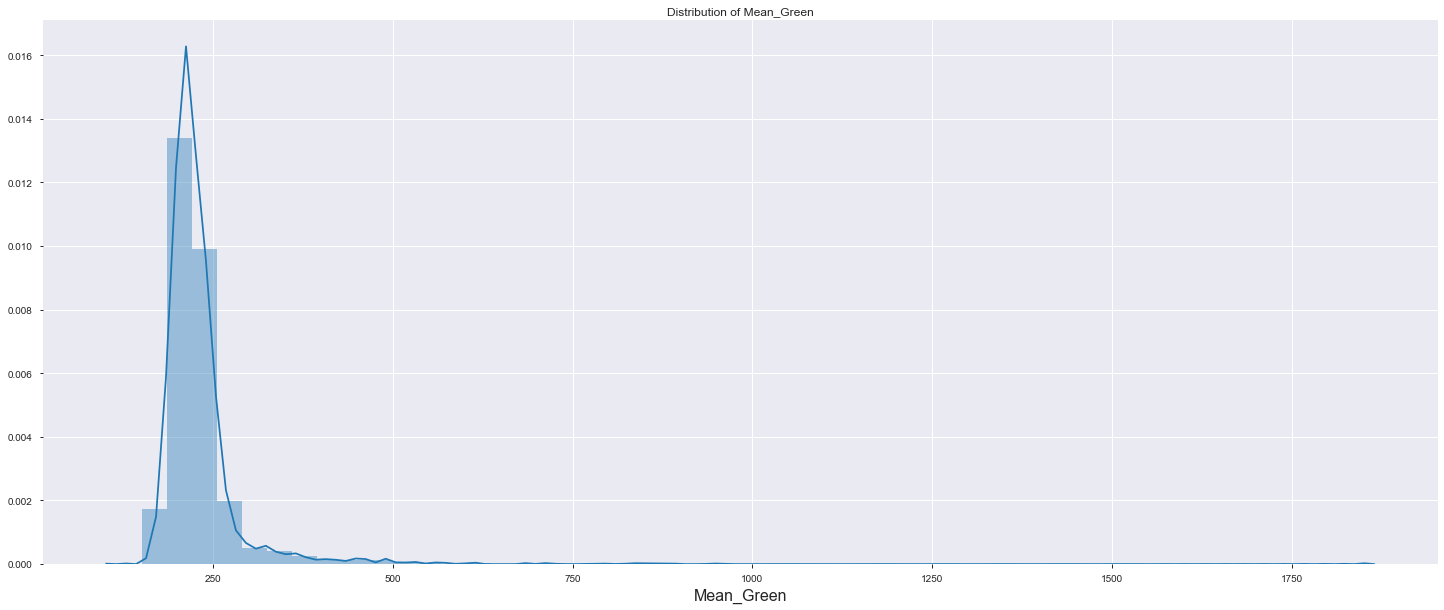

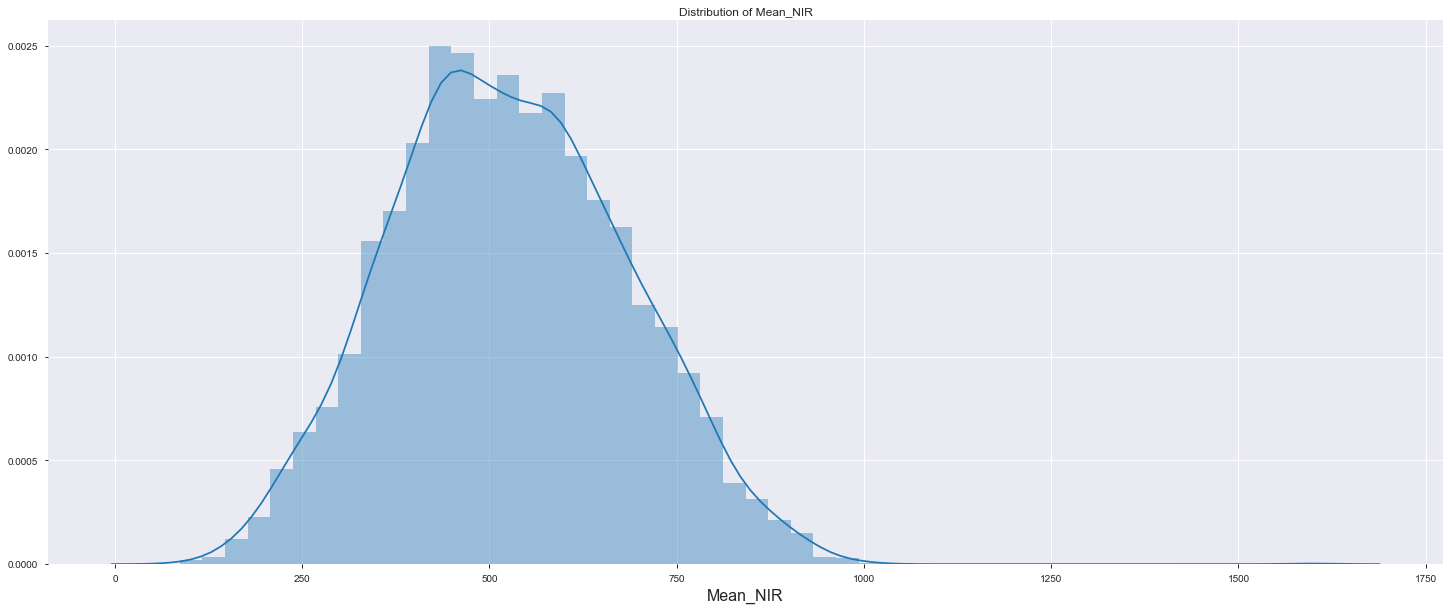

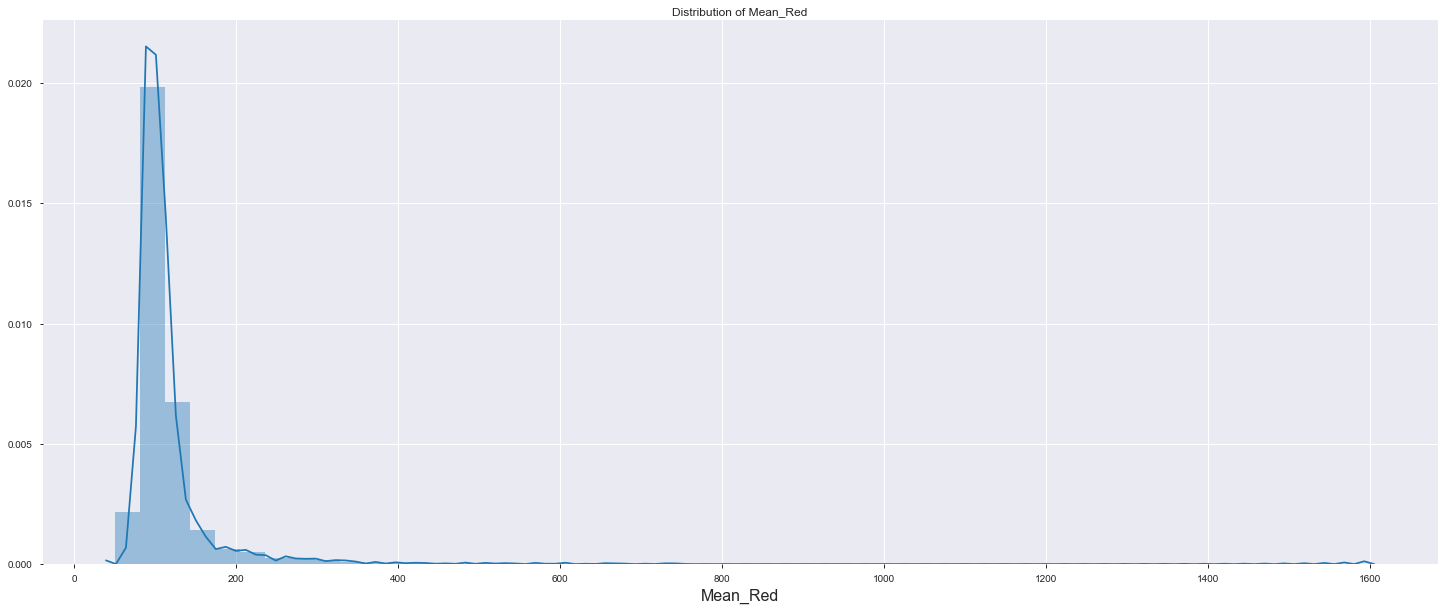

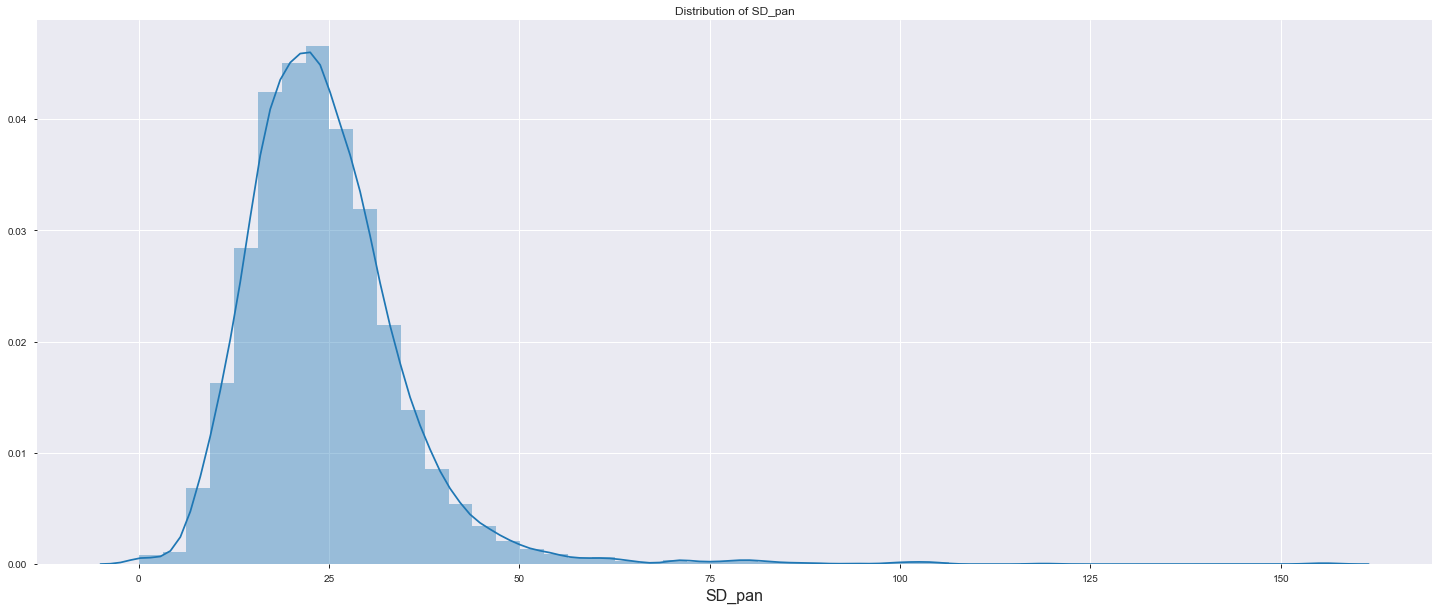

In [12]:
for feat in features:
    plt.figure()
#     sns.distplot(data.loc[data["class"] == 'n', :][feat])
#     sns.distplot(data.loc[data["class"] == 'w', :][feat])
    sns.distplot(data[feat])
    plt.title("Distribution of " + feat);
    plt.xlabel(feat);

We can see that both `GLCM_pan` and `Mean_NIR` have a fairly Gaussian distribution, where as the rest of the variables are right skewed. Keep note of this because it might help us in the future.

### Pairplot

This pairplot gives us a univariate and bivariate analysis of the features in the dataset. We will see distributions of the features, as well as the features plotted against one another in a scatter plot. This might show us some correlation in the features.

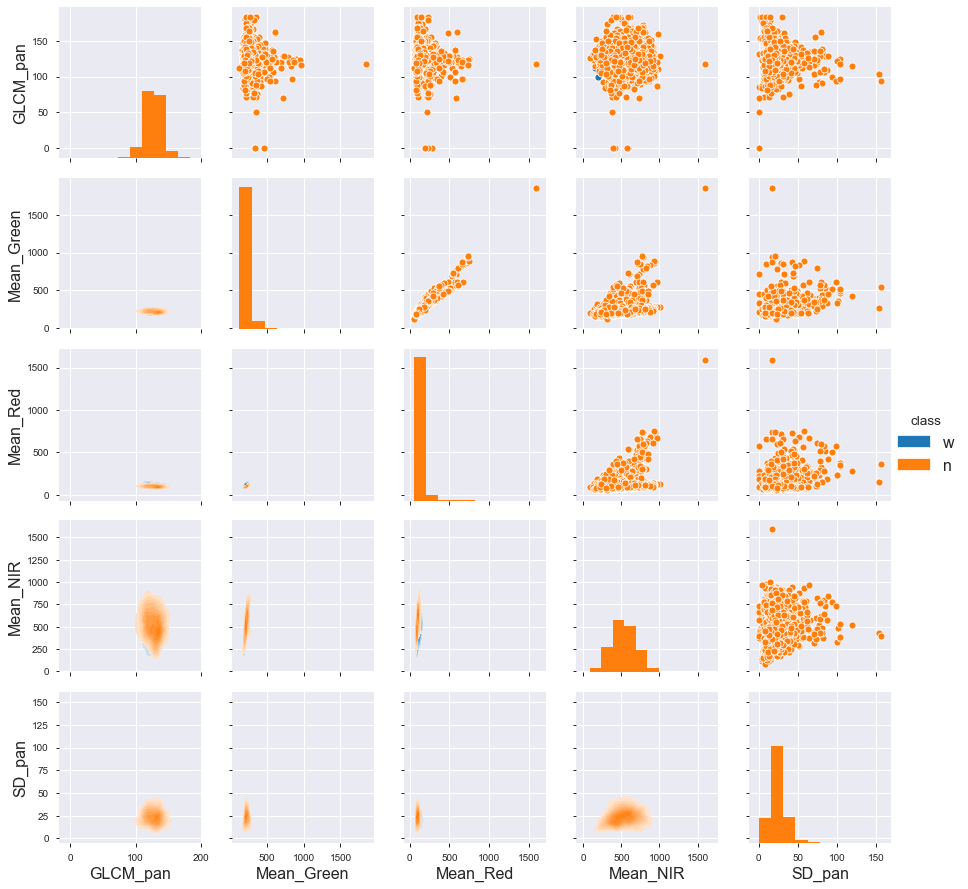

In [29]:
g = sns.PairGrid(data, hue = "class")
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.kdeplot, shade = True, shade_lowest = False)
g = g.map_diag(plt.hist)
g = g.add_legend()

We tried to split and plot the data by class, but we can barely see the class `w`, as it is being almost entirely covered by the class `n`. This lack of separation might make it difficult for our classifiers to correctly classify the data.

### Countplot of class

So let us look at the counts of the classes, to see if there is class imbalance.

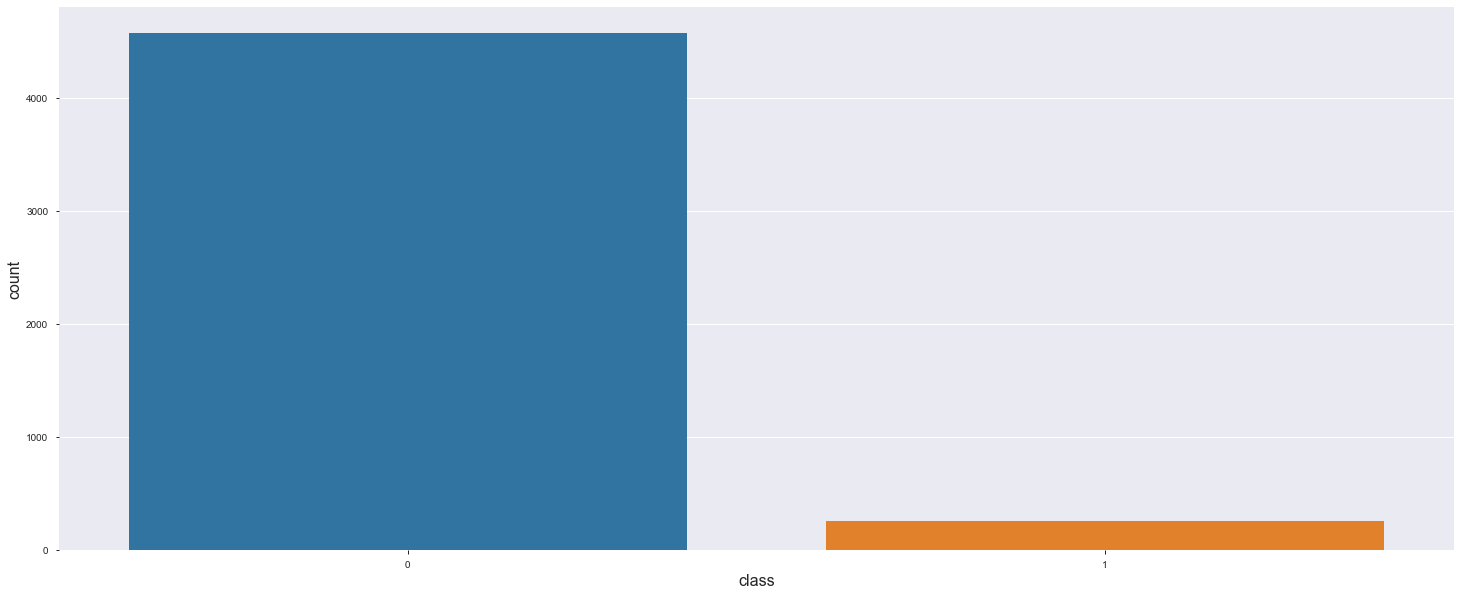

In [13]:
sns.countplot(data["class"]);

As expected, the outlier class is way more underrepresented than the inlier class.

### Correlation matrix

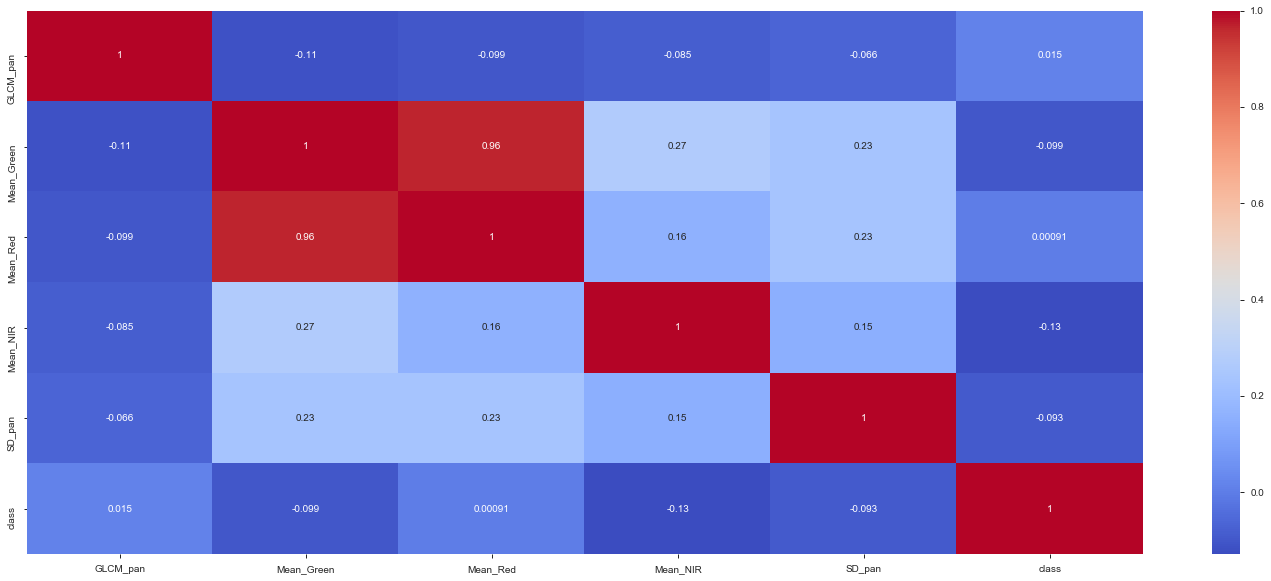

In [14]:
sns.heatmap(data.corr(), annot=True, cmap="coolwarm");

We can see that `Mean_Green` and `Mean_Red` are highly correlated to one another

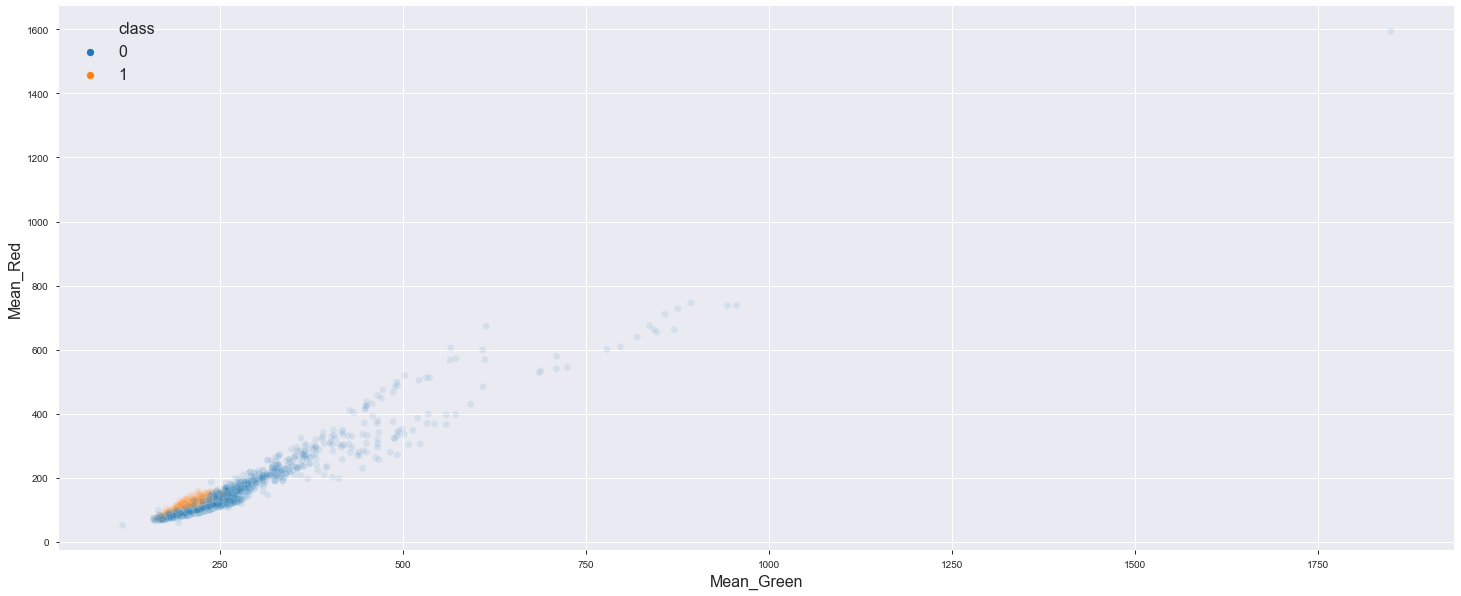

In [15]:
sns.scatterplot(data=data, x="Mean_Green", y="Mean_Red", hue="class", alpha=0.1);

## tSNE

In [16]:
tsne_df = data.copy()
rndperm = np.random.permutation(len(tsne_df))

In [17]:
df_subset = tsne_df.loc[rndperm,:].copy()
data_subset = df_subset.values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.76730192 0.22046701 0.00546737]


In [18]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4839 samples in 0.002s...
[t-SNE] Computed neighbors for 4839 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4839
[t-SNE] Computed conditional probabilities for sample 2000 / 4839
[t-SNE] Computed conditional probabilities for sample 3000 / 4839
[t-SNE] Computed conditional probabilities for sample 4000 / 4839
[t-SNE] Computed conditional probabilities for sample 4839 / 4839
[t-SNE] Mean sigma: 8.738421
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.761490
[t-SNE] KL divergence after 300 iterations: 1.380800


In [19]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['tsne-2d-three'] = tsne_results[:,2]

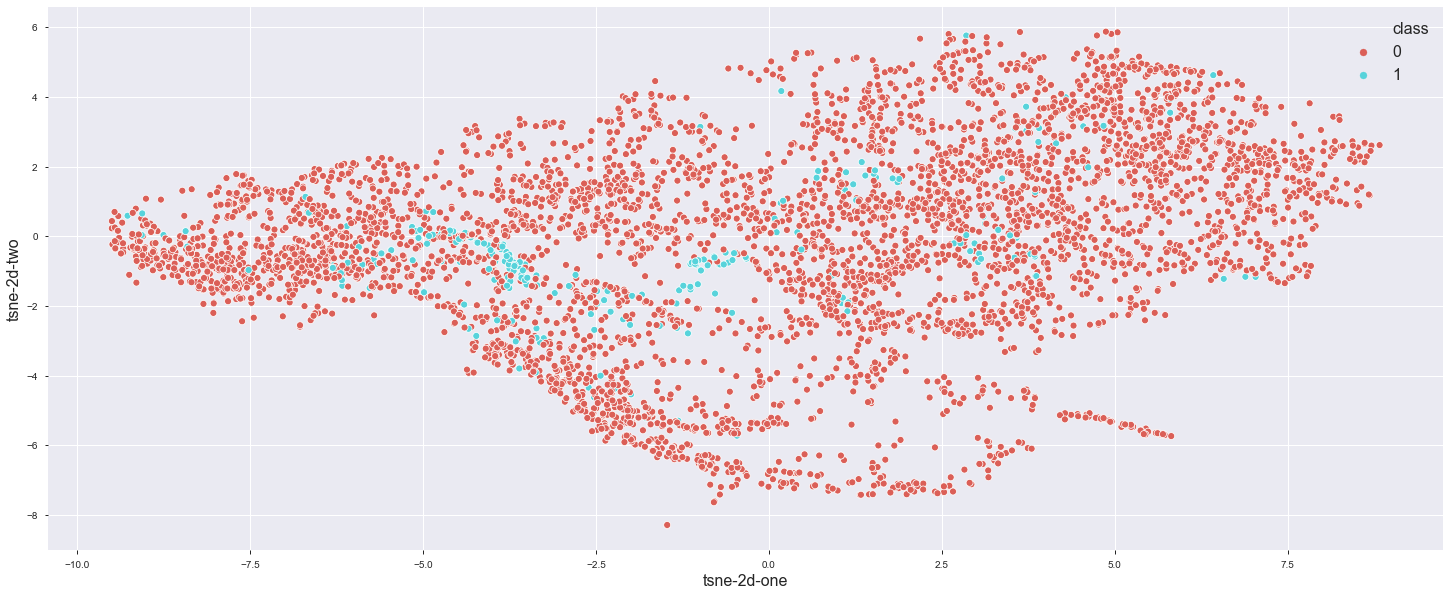

In [20]:
sns.scatterplot(x="tsne-2d-one", 
                y="tsne-2d-two",
                hue="class",
                palette=sns.color_palette("hls", 2),
                data=df_subset,
                legend="full"
               );

''

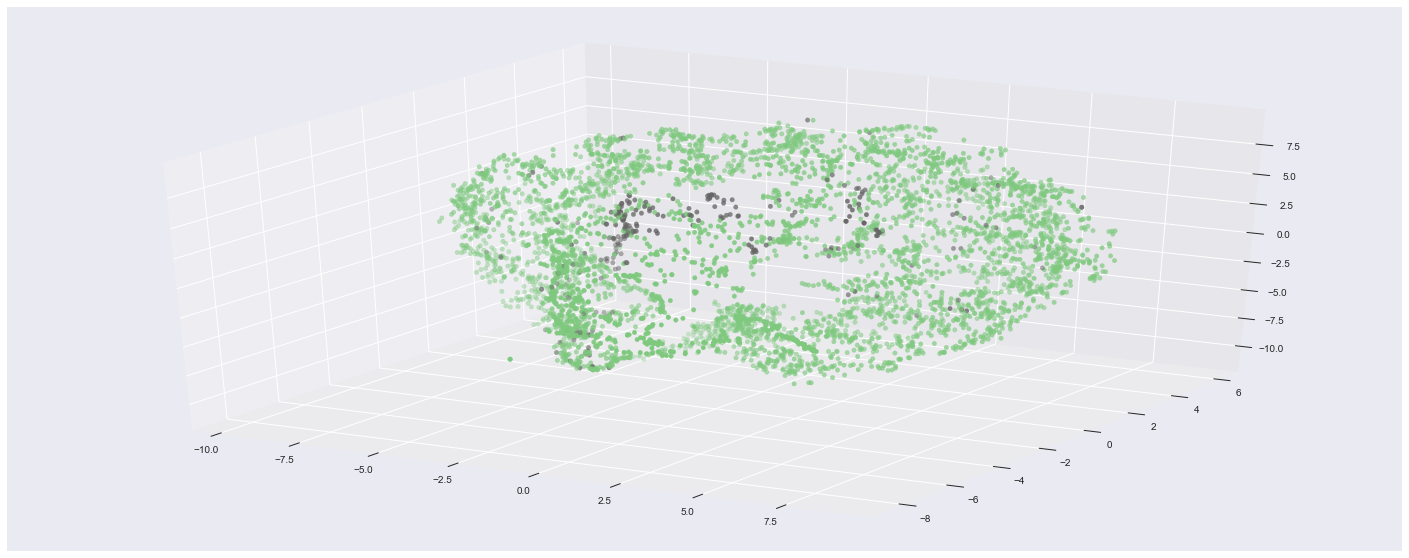

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=df_subset["tsne-2d-one"], 
           ys=df_subset["tsne-2d-two"], 
           zs=df_subset["tsne-2d-three"], 
           c=df_subset["class"],
           cmap="Accent"
          )
;

## Kernel PCA

In [22]:
kpca_df = data.copy()
X = kpca_df.drop("class", axis=1)
y = kpca_df["class"]

In [23]:
# Perform Kernel PCA
kernel_pca = KernelPCA(n_components=3, kernel="rbf", fit_inverse_transform=True, gamma=1/X.shape[0])
X_kernel_pca = kernel_pca.fit_transform(X)

xs = X_kernel_pca[:, 0]
ys = X_kernel_pca[:, 1]
zs = X_kernel_pca[:, 2]

In [24]:
X_kernel_pca.shape

(4839, 3)

''

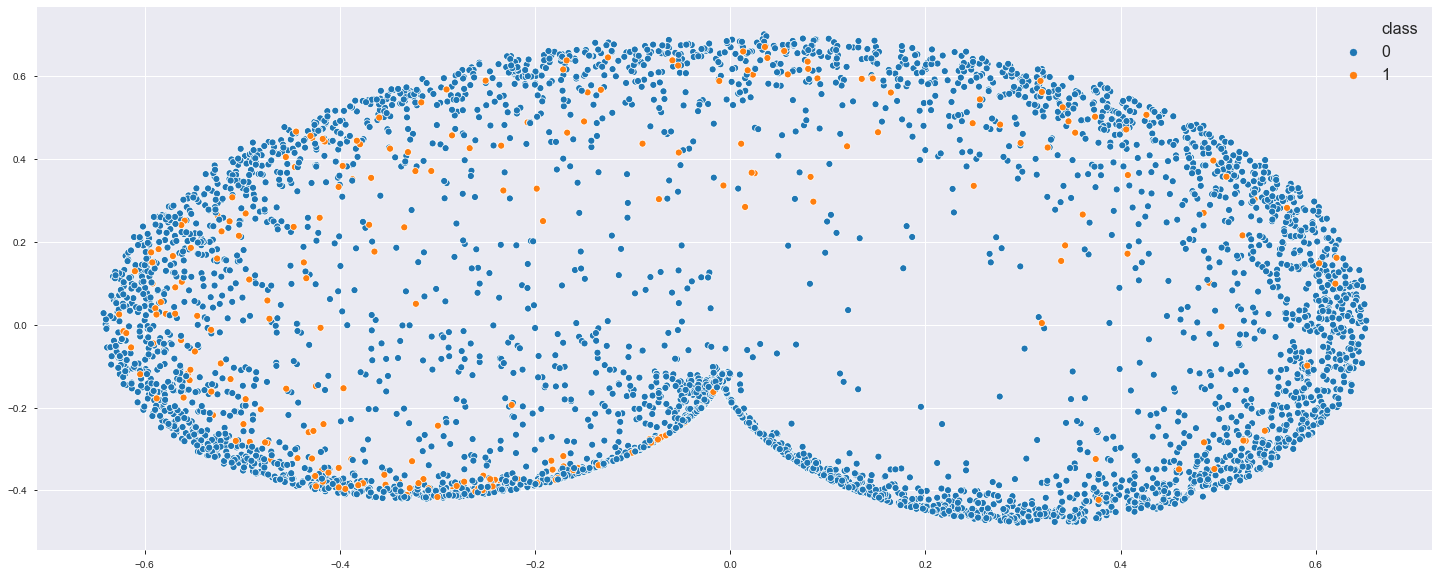

In [25]:
sns.scatterplot(x=xs, 
                y=ys, 
                hue=data["class"]
               )
;

''

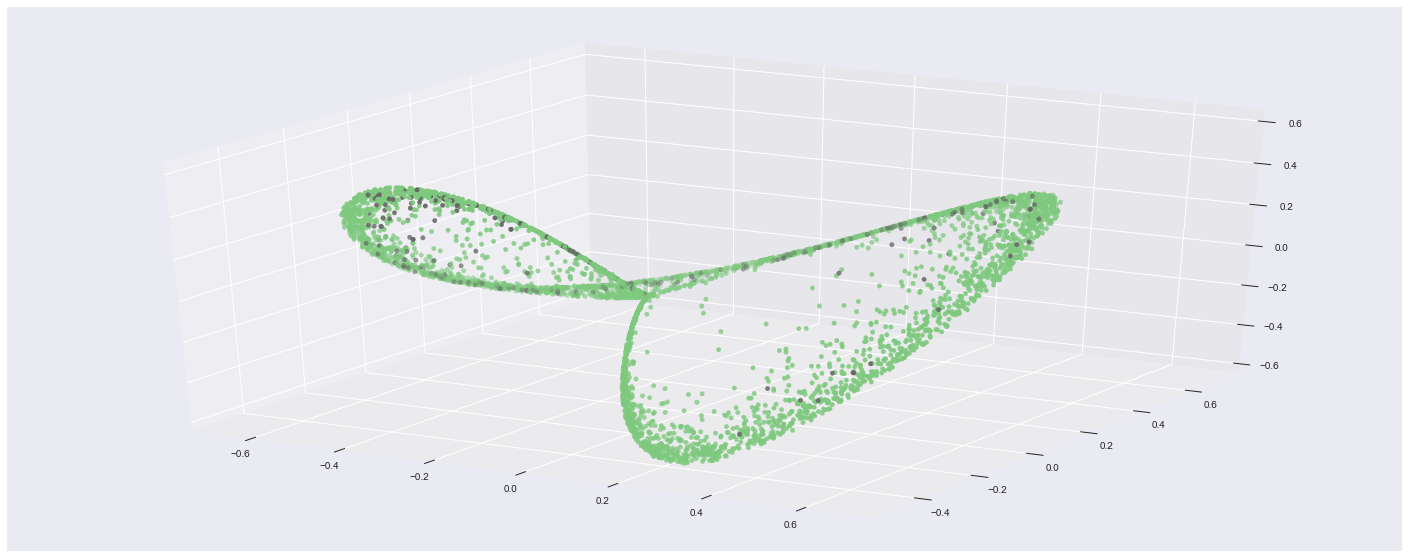

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=xs, 
           ys=ys, 
           zs=zs, 
           c=data["class"],
           cmap="Accent"
          )
;

So performing tSNE and KPCA on the data doesn't seem to be producing any sort of separation on the outliers from the inliers. Let's try transforming the data to see if that can help in creating separation.

## tSNE and kPCA on transformed data

We will apply the Power Transform on each of the features to make them Gaussian.

In [27]:
# Applying power transform to columns to make them more Gaussian
pt = PowerTransformer()
for feat in features:
    pt_col = pt.fit_transform(data[[feat]])
    data["pt_" + feat] = pt_col

In [28]:
pt_features = ['pt_GLCM_pan', 'pt_Mean_Green', 'pt_Mean_NIR', 'pt_Mean_Red', 'pt_SD_pan']

In [29]:
pt_data = pd.concat([data[pt_features], pd.DataFrame(data["class"])], axis=1)
pt_data.head()

pt_GLCM_pan  pt_Mean_Green  pt_Mean_NIR  pt_Mean_Red  pt_SD_pan  class
0    -0.526341      -0.537940    -0.673965     0.656029  -0.260532      1
1    -0.200426      -0.656314    -1.099614     0.523453  -0.739662      1
2     0.571704      -0.818771    -0.269908     0.574768  -0.061838      1
3     0.043678      -2.028264    -1.644112    -0.572608  -0.973015      1
4     0.630786      -0.929851     0.082690     0.429605  -0.625072      1

### tSNE

In [30]:
tsne_df = pt_data.copy()
rndperm = np.random.permutation(len(tsne_df))

In [31]:
df_subset = tsne_df.loc[rndperm,:].copy()
data_subset = df_subset.values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.45123752 0.19664402 0.18525211]


In [32]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4839 samples in 0.002s...
[t-SNE] Computed neighbors for 4839 samples in 0.218s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4839
[t-SNE] Computed conditional probabilities for sample 2000 / 4839
[t-SNE] Computed conditional probabilities for sample 3000 / 4839
[t-SNE] Computed conditional probabilities for sample 4000 / 4839
[t-SNE] Computed conditional probabilities for sample 4839 / 4839
[t-SNE] Mean sigma: 0.373409
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.407784
[t-SNE] KL divergence after 300 iterations: 1.593650


In [33]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['tsne-2d-three'] = tsne_results[:,2]

''

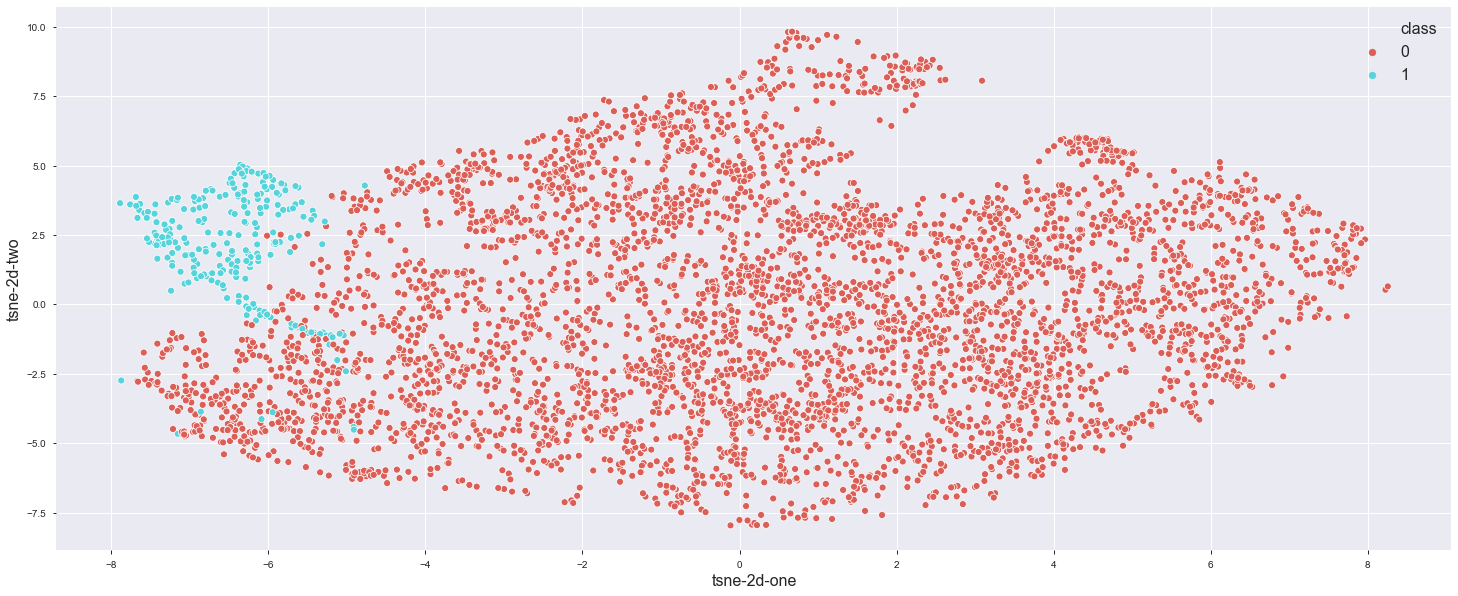

In [34]:
sns.scatterplot(x="tsne-2d-one", 
                y="tsne-2d-two",
                hue="class",
                palette=sns.color_palette("hls", 2),
                data=df_subset,
                legend="full"
               )
;

We can see here that there is much more separation with the power-transformed data. It looks like we might be able to create more separation if we raise this data to higher dimension by plotting with the third principal component!

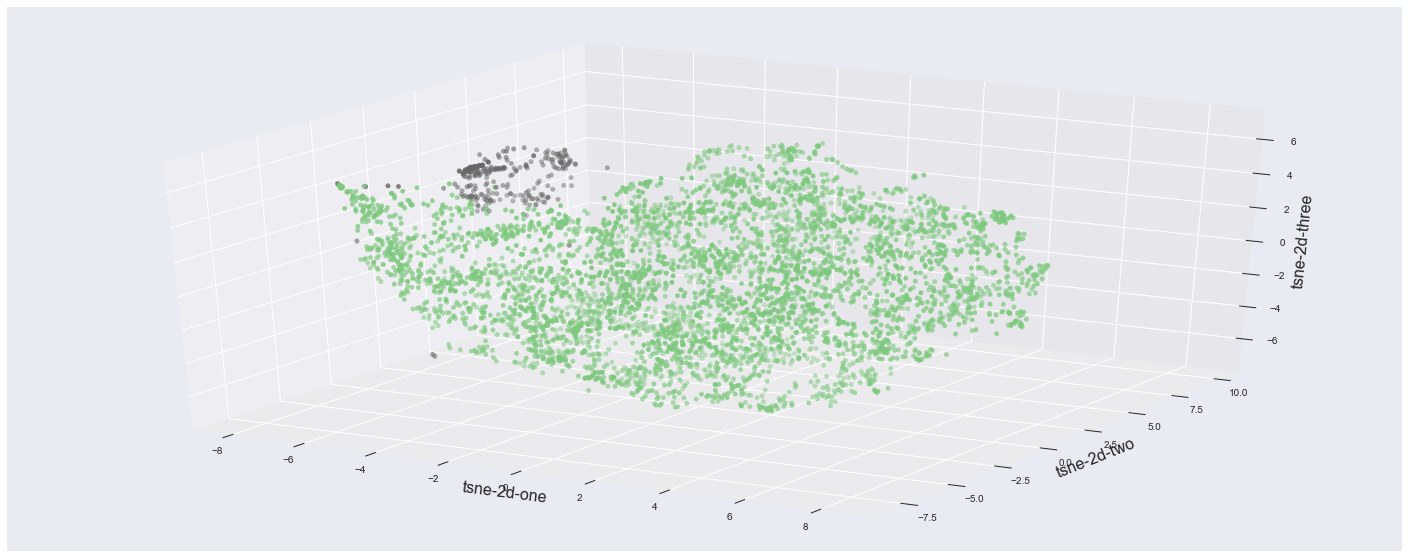

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=df_subset["tsne-2d-one"], 
           ys=df_subset["tsne-2d-two"], 
           zs=df_subset["tsne-2d-three"], 
           c=df_subset["class"],
           cmap="Accent"
          );

ax.set_xlabel("tsne-2d-one");
ax.set_ylabel("tsne-2d-two");
ax.set_zlabel("tsne-2d-three");

We can create nearly perfect separation amongst the data with tSNE on the power-transformed data in three dimensions

In [36]:
new_data = pd.concat([df_subset[["tsne-2d-one", "tsne-2d-two", "tsne-2d-three"]], data[["class"]]], axis=1)

In [38]:
mms = MinMaxScaler()
# rs = RobustScaler()
# ss = StandardScaler()

## Splitting the data

In [37]:
X = new_data.drop("class", axis=1)
y = new_data["class"]

In [39]:
mm_scaled = pd.DataFrame(mms.fit_transform(X), columns=X.columns)
# rs_scaled = pd.DataFrame(rs.fit_transform(X), columns=X.columns)
# ss_scaled = pd.DataFrame(ss.fit_transform(X), columns=X.columns)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Anomaly detection

### DBScan

In [54]:
dbs = DBSCAN(eps = 1.3, 
             metric="euclidean", 
             min_samples=15, 
             n_jobs=-1
            )

clusters = dbs.fit_predict(X)
np.unique(clusters, return_counts=True)

(array([-1,  0,  1]), array([  11,  252, 4576]))

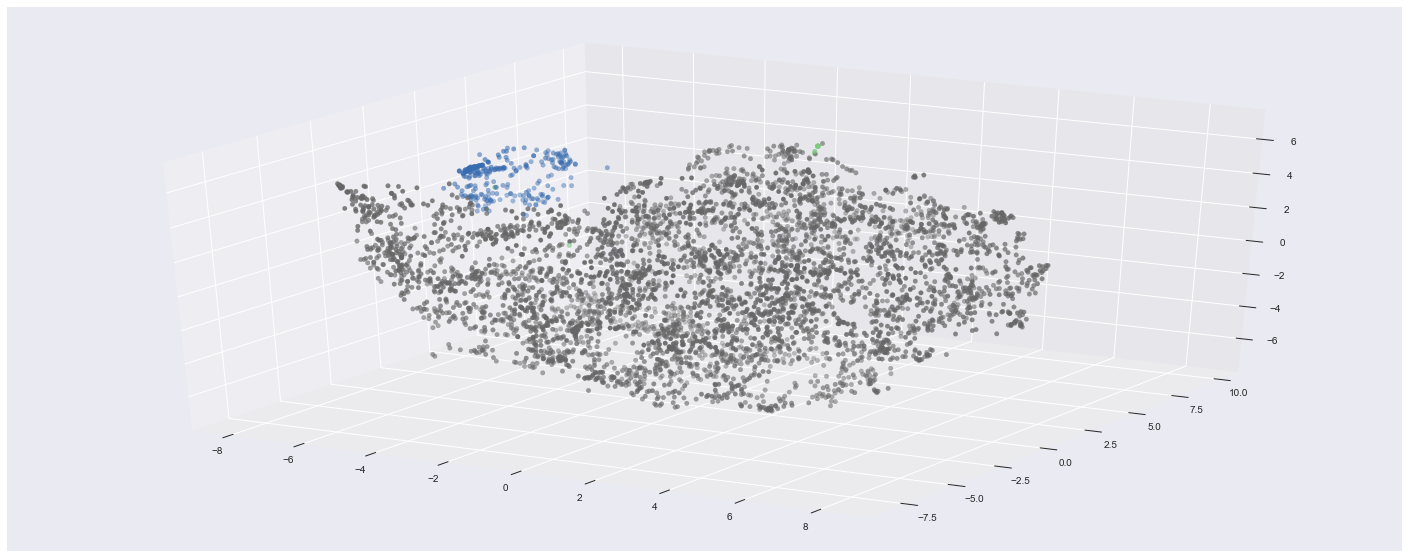

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=X["tsne-2d-one"], 
           ys=X["tsne-2d-two"], 
           zs=X["tsne-2d-three"], 
           c=clusters,
           cmap="Accent"
          );

So we can see here that DBScan is doing a pretty good job identifying the outliers as a separate clustering the outliers from the inliers. But it mistakenly identifies a third class, which does not exist.

## Isolation forest

In [166]:
isof = IsolationForest(n_estimators=200, 
                       max_samples=30, 
                       contamination=data["class"].mean(), 
                       max_features=3, 
                       bootstrap=False, 
                       behaviour="old", 
                       random_state=None,  
                       warm_start=False)

In [167]:
if_pred = isof.fit_predict(mm_scaled)
if_pred_map = pd.DataFrame(if_pred)[0].map({1:0, -1:1})
np.unique(if_pred_map, return_counts=True)

(array([0, 1]), array([4578,  261]))

In [170]:
recall_score(y, if_pred_map)

0.39846743295019155

In [171]:
precision_score(y, if_pred_map)

0.39846743295019155

In [172]:
if_pred = isof.fit_predict(ss_scaled)
if_pred_map = pd.DataFrame(if_pred)[0].map({1:0, -1:1})
np.unique(if_pred_map, return_counts=True)

(array([0, 1]), array([4580,  259]))

In [173]:
recall_score(y, if_pred_map)

0.3486590038314176

In [174]:
precision_score(y, if_pred_map)

0.35135135135135137

In [175]:
if_pred = isof.fit_predict(rs_scaled)
if_pred_map = pd.DataFrame(if_pred)[0].map({1:0, -1:1})
np.unique(if_pred_map, return_counts=True)

(array([0, 1]), array([4578,  261]))

In [176]:
recall_score(y, if_pred_map)

0.34099616858237547

In [177]:
precision_score(y, if_pred_map)

0.34099616858237547

## One-Class SVM

In [43]:
oc_data = new_data[new_data["class"] == 1]
oc_X = oc_data.drop("class", axis=1)

In [44]:
one_class = OneClassSVM()

In [45]:
clf = one_class.fit(oc_X);

/Users/stiwari/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [46]:
predictions = clf.predict(new_data.drop("class", axis=1))
np.unique(predictions, return_counts=True)

(array([-1,  1]), array([4707,  132]))

In [47]:
predictions = (predictions+1)/2

In [48]:
recall_score(predictions, y)

1.0

In [49]:
precision_score(predictions, y)

0.5057471264367817

''

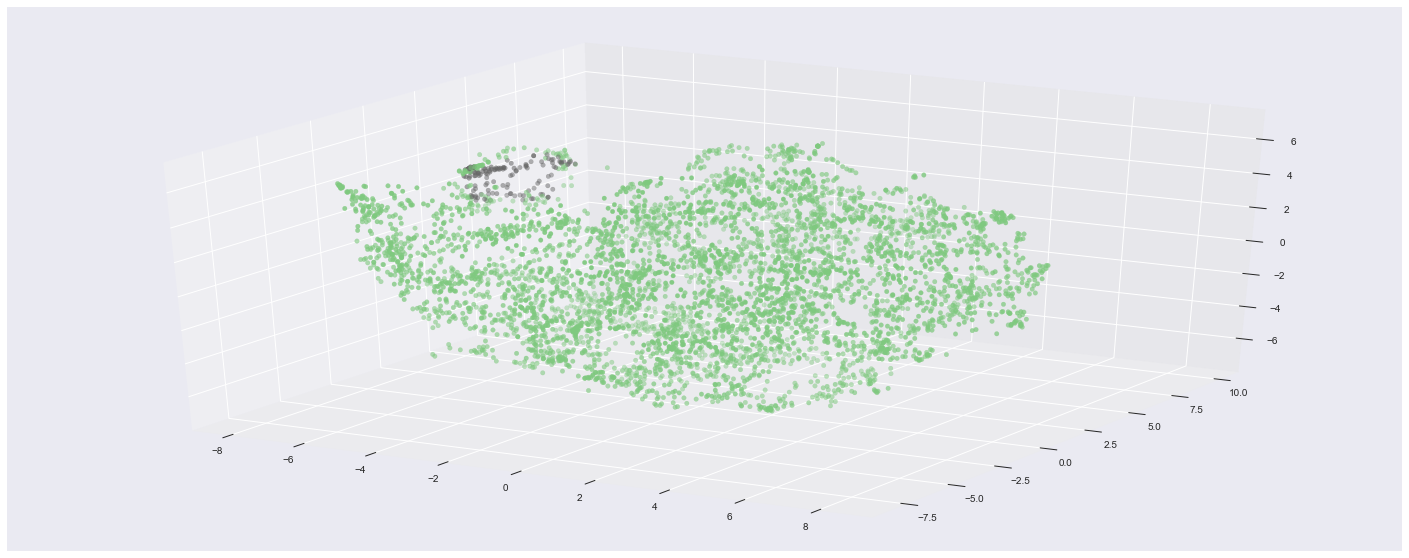

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=X["tsne-2d-one"], 
           ys=X["tsne-2d-two"], 
           zs=X["tsne-2d-three"], 
           c=predictions,
           cmap="Accent"
          )
;

So the One-SVM classifier appears to have decent performance in classifying the outliers, as there is 100% recall, meaning that of all the outliers are correctly being classified as such. It is also identifying only the two classes 